In [2]:
import os
os.chdir("D:\Abhinav Tar Files\Snapshots")

In [3]:
import numpy as np
from ReadFile import Read
from CenterOfMass2 import CenterOfMass
import matplotlib.pyplot as plt

# -------------------------------------------------
# Compute tangential unit vectors
# -------------------------------------------------
def spherical_velocities(pos, vel):
    x, y, z = pos[:,0], pos[:,1], pos[:,2]
    vx, vy, vz = vel[:,0], vel[:,1], vel[:,2]

    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)

    # Unit vectors
    e_phi = np.vstack([-np.sin(phi), np.cos(phi), np.zeros_like(phi)]).T

    # Tangential velocity Vphi
    v_phi = np.sum(vel * e_phi, axis=1)
    return r, v_phi


# -------------------------------------------------
# Angular momentum and spin parameter
# -------------------------------------------------
def specific_angular_momentum(pos, vel, masses):
    L = np.sum(np.cross(pos, vel) * masses[:,None], axis=0)
    M_tot = np.sum(masses)
    return L / M_tot


def bullock_spin_parameter(pos, vel, masses):
    """ Bullock et al. 2001 spin parameter λ' = j / (√2 * Vvir * Rvir) """
    # Approximate virial radius = radius enclosing 200 * mean density
    r = np.linalg.norm(pos, axis=1)
    M_tot = np.sum(masses)
    Rvir = np.percentile(r, 90)   # quick estimator for halo boundary
    G = 4.498e-6  # kpc^3 / (Msun * Myr^2)

    Vvir = np.sqrt(G * M_tot / Rvir)
    j = np.linalg.norm(specific_angular_momentum(pos, vel, masses))

    return j / (np.sqrt(2) * Vvir * Rvir)


# -------------------------------------------------
# Escape speed v_esc(r) = sqrt(2 G M(<r) / r)
# -------------------------------------------------
def escape_speed(r, masses, radii_sorted):
    G = 4.498e-6
    M_enc = np.cumsum(masses[np.argsort(radii_sorted)])
    M_interp = np.interp(r, radii_sorted, M_enc)
    return np.sqrt(2 * G * M_interp / r)


# -------------------------------------------------
# MAIN LOOP
# -------------------------------------------------
snapshots = np.arange(0, 800)
r_bins = np.logspace(-1, 2.7, 40)

rot_curve_matrix = np.zeros((len(snapshots), len(r_bins)-1))
j_spec_matrix  = np.zeros((len(snapshots), 3))
spin_param     = np.zeros(len(snapshots))
esc_matrix     = np.zeros((len(snapshots), len(r_bins)-1))

count = 0

for idx, snap in enumerate(snapshots):

    mw_file  = f"MW_{snap:03d}.txt"
    m31_file = f"M31_{snap:03d}.txt"

    MW  = CenterOfMass(mw_file, 1)
    M31 = CenterOfMass(m31_file, 1)

    x = np.concatenate((MW.x, M31.x))
    y = np.concatenate((MW.y, M31.y))
    z = np.concatenate((MW.z, M31.z))
    vx = np.concatenate((MW.vx, M31.vx))
    vy = np.concatenate((MW.vy,  M31.vy))
    vz = np.concatenate((MW.vz,  M31.vz))
    m = np.concatenate((MW.m,   M31.m))
    
    pos = np.vstack((x, y, z)).T
    vel = np.vstack((vx, vy, vz)).T

    # COM centering
    xcom, ycom, zcom = MW.COMdefine(x, y, z, m)
    vxcom, vycom, vzcom = MW.COMdefine(vx, vy, vz, m)

    pos -= np.array([xcom, ycom, zcom])
    vel -= np.array([vxcom, vycom, vzcom])

    # Rotation curve
    r, v_phi = spherical_velocities(pos, vel)
    rot = np.zeros(len(r_bins)-1)
    vesc_prof = np.zeros(len(r_bins)-1)

    # Sorting for enclosed mass (escape speed)
    idx_sort = np.argsort(r)
    radii_sorted = r[idx_sort]
    mass_sorted = m[idx_sort]

    for i in range(len(r_bins)-1):
        mask = (r >= r_bins[i]) & (r < r_bins[i+1])
        if np.any(mask):
            rot[i] = np.mean(v_phi[mask])

        # Escape speed profile
        r_mid = np.sqrt(r_bins[i] * r_bins[i+1])
        vesc = escape_speed(r_mid, mass_sorted, radii_sorted)
        vesc_prof[i] = vesc

    rot_curve_matrix[idx] = rot
    esc_matrix[idx] = vesc_prof

    # Specific angular momentum & spin parameter
    j_spec_matrix[idx] = specific_angular_momentum(pos, vel, m)
    spin_param[idx] = bullock_spin_parameter(pos, vel, m)

    count += 1
    print(f"Processed {count} snapshots out of {len(snapshots)} (last = {snap})")


print("\nAll snapshots processed.")
print(f"Merger snapshot reference = 445")


Processed 1 snapshots out of 800 (last = 0)
Processed 2 snapshots out of 800 (last = 1)
Processed 3 snapshots out of 800 (last = 2)
Processed 4 snapshots out of 800 (last = 3)
Processed 5 snapshots out of 800 (last = 4)
Processed 6 snapshots out of 800 (last = 5)
Processed 7 snapshots out of 800 (last = 6)
Processed 8 snapshots out of 800 (last = 7)
Processed 9 snapshots out of 800 (last = 8)
Processed 10 snapshots out of 800 (last = 9)
Processed 11 snapshots out of 800 (last = 10)
Processed 12 snapshots out of 800 (last = 11)
Processed 13 snapshots out of 800 (last = 12)
Processed 14 snapshots out of 800 (last = 13)
Processed 15 snapshots out of 800 (last = 14)
Processed 16 snapshots out of 800 (last = 15)
Processed 17 snapshots out of 800 (last = 16)
Processed 18 snapshots out of 800 (last = 17)
Processed 19 snapshots out of 800 (last = 18)
Processed 20 snapshots out of 800 (last = 19)
Processed 21 snapshots out of 800 (last = 20)
Processed 22 snapshots out of 800 (last = 21)
Process

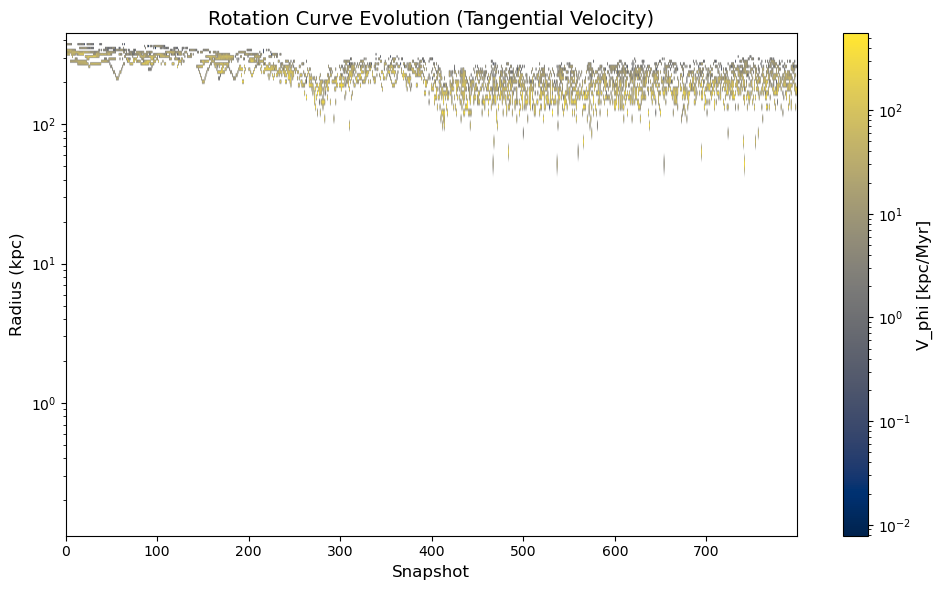

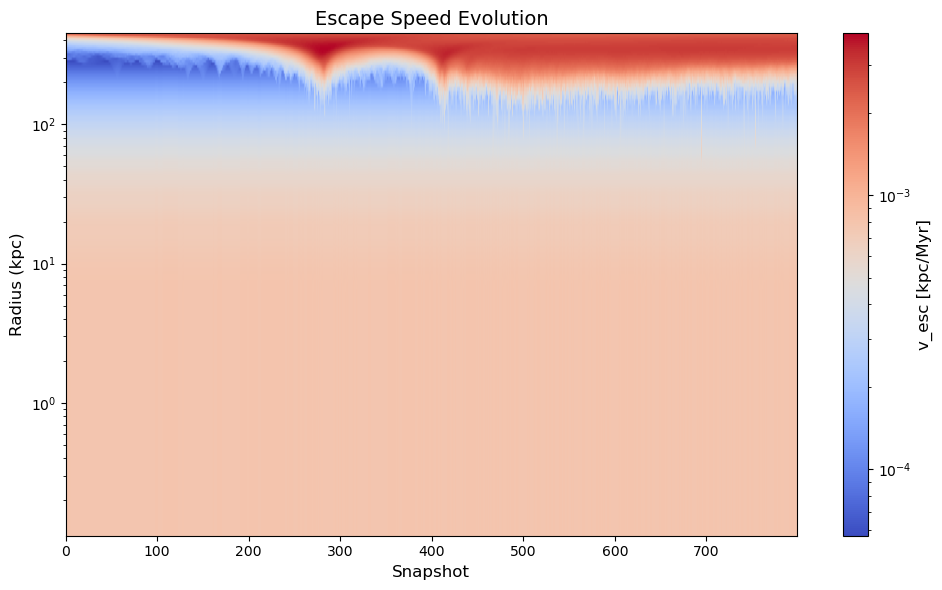

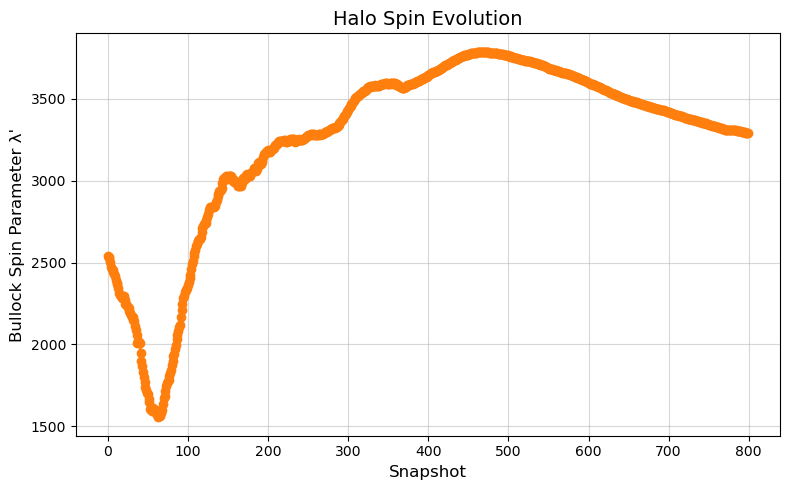

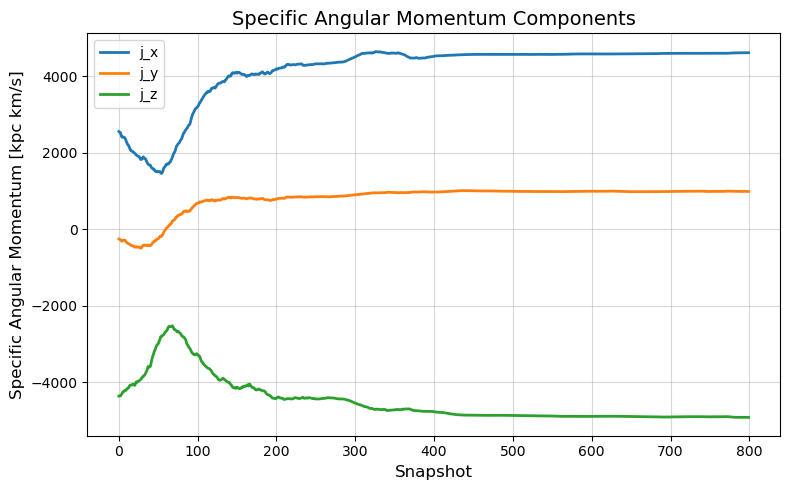

In [7]:
from matplotlib.colors import LogNorm

# Midpoint radii
r_mid = np.sqrt(r_bins[:-1] * r_bins[1:])

# -------------------------------------------------
# 1. Rotation curve heatmap
# -------------------------------------------------
plt.figure(figsize=(10,6))
plt.imshow(rot_curve_matrix.T, aspect='auto', origin='lower',
           extent=[snapshots[0], snapshots[-1], r_mid[0], r_mid[-1]],
           cmap='cividis', norm=LogNorm())  # perceptually uniform, log-scaled
cbar = plt.colorbar()
cbar.set_label('V_phi [kpc/Myr]', fontsize=12)
plt.yscale('log')
plt.xlabel("Snapshot", fontsize=12)
plt.ylabel("Radius (kpc)", fontsize=12)
plt.title("Rotation Curve Evolution (Tangential Velocity)", fontsize=14)
plt.tight_layout()
plt.savefig("rotation_curve_evolution.png", dpi=300)
plt.show()

# -------------------------------------------------
# 2. Escape speed heatmap
# -------------------------------------------------
plt.figure(figsize=(10,6))
plt.imshow(esc_matrix.T, aspect='auto', origin='lower',
           extent=[snapshots[0], snapshots[-1], r_mid[0], r_mid[-1]],
           cmap='coolwarm', norm=LogNorm())  # diverging colormap emphasizes contrast
cbar = plt.colorbar()
cbar.set_label('v_esc [kpc/Myr]', fontsize=12)
plt.yscale('log')
plt.xlabel("Snapshot", fontsize=12)
plt.ylabel("Radius (kpc)", fontsize=12)
plt.title("Escape Speed Evolution", fontsize=14)
plt.tight_layout()
plt.savefig("escape_speed_evolution.png", dpi=300)
plt.show()

# -------------------------------------------------
# 3. Spin parameter over time
# -------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(snapshots, spin_param, marker='o', color='tab:orange', linewidth=2)
plt.xlabel("Snapshot", fontsize=12)
plt.ylabel("Bullock Spin Parameter λ'", fontsize=12)
plt.title("Halo Spin Evolution", fontsize=14)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.savefig("spin_evolution.png", dpi=300)
plt.show()

# -------------------------------------------------
# 4. Specific angular momentum components
# -------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(snapshots, j_spec_matrix[:,0], label='j_x', color='tab:blue', linewidth=2)
plt.plot(snapshots, j_spec_matrix[:,1], label='j_y', color='tab:orange', linewidth=2)
plt.plot(snapshots, j_spec_matrix[:,2], label='j_z', color='tab:green', linewidth=2)
plt.xlabel("Snapshot", fontsize=12)
plt.ylabel("Specific Angular Momentum [kpc km/s]", fontsize=12)
plt.title("Specific Angular Momentum Components", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.savefig("j_components.png", dpi=300)
plt.show()


In [11]:
import os

png_files = [f for f in os.listdir(os.getcwd()) if f.endswith('.png')]

print(png_files)


['inertia_eigenvalues.png', 'radial_axis_ratios.png', 'halo_shape_evolution.png', 'density_methods_evolution_heatmaps.png', 'velocity_dispersion_evolution.png', 'rotation_curve_evolution.png', 'escape_speed_evolution.png', 'spin_evolution.png', 'j_components.png']
